#### Date: Jun 2019 (*Review: March 2024*)<br>Programmer:  Christian Dittmar, Yiğitcan Özer

#### The notebook proceeds in the following steps:
<br>1. It loads an example audio file containing a drum recording
<br>2. It computes the STFT of the audio data.
<br>3. It applies NMFD as described in [1], with audio-informed initialization of the components
<br>4. It visualizes the decomposition results.
<br>5. It resynthesizes the separated audio streams and saves them as wav files to the hard drive.

In [1]:
import os
import numpy as np
import soundfile as sf
import IPython.display as ipd

from libnmfd.core.nmfconv import init_activations, init_templates, nmfd
from libnmfd.dsp.filters import alpha_wiener_filter
from libnmfd.dsp.transforms import forward_stft, inverse_stft
from libnmfd.utils import make_monaural, pcm_int16_to_float32np
from libnmfd.utils.core_utils import visualize_components_nmf

INPUT_DIR = 'data/'
OUT_DIR = 'output/'

# create the output directory if it doesn't exist
if not os.path.isdir(OUT_DIR):
    os.makedirs(OUT_DIR)

# convert wav from int16 to float32
filename = 'runningExample_AmenBreak.wav'

### 1. Load the audio signal

In [2]:
x, fs = sf.read(file=os.path.join(INPUT_DIR, filename),dtype=np.float32)

# make monaural if necessary
x = make_monaural(x)

In [25]:
desired_drum_classes = ['kick', 'snare', 'hihat']

# set common parameters
num_comp = 3
num_iter = 30
num_template_frames = 8

# spectral parameters
BLOCK_SIZE = 2048
HOP_SIZE = 512

counter = 0
init_W_drums = list()



for drum_class in desired_drum_classes:
    # parse all audio files
    
    drum_audio_files = os.listdir(os.path.join(INPUT_DIR, drum_class))
    print(drum_audio_files)

    drum_class_audios = None
    
    for drum_audio_file in drum_audio_files:
        dx, fs = sf.read(file=os.path.join(INPUT_DIR, drum_class, drum_audio_file),dtype=np.float32)

        # make monaural if necessary
        dx = make_monaural(dx)

        # normalize amplitude
        dx = 0.99 * dx / np.max(np.abs(dx))

        # concatenate all audios for one drum class
        if drum_class_audios is None:
            drum_class_audios = dx.copy()
        else:
            drum_class_audios = np.hstack([drum_class_audios, dx])


    
    # STFT computation
    _, A, _ = forward_stft(drum_class_audios, block_size=BLOCK_SIZE, hop_size=HOP_SIZE, reconst_mirror=True, append_frames=True)

    # get dimensions and time and freq resolutions
    num_bins, num_frames = A.shape
    time_res = HOP_SIZE / fs
    freq_res = fs / BLOCK_SIZE    

    # generate initial guess for templates
    init_W = init_templates(num_comp=1,
                            num_bins=num_bins,
                            strategy='random')
    
    # generate initial activations
    init_H = init_activations(num_comp=1,
                              num_frames=num_frames,
                              strategy='uniform')    

    # NMFD core method
    nmfd_W, nmfd_H, nmfd_V, divKL, _ = nmfd(V=A, 
                                            num_comp=1, 
                                            num_frames=num_frames, 
                                            num_iter=num_iter,
                                            num_template_frames=num_template_frames,
                                            init_W=init_W,
                                            init_H=init_H)


    #print(nmfd_W.shape)

    if init_W_drums is None:
        #nit_W_drums = np.zeros((num_bins, len(desired_drum_classes), num_template_frames))
        init_W_drums.append(nmfd_W.as_array().copy())
    

        
    

['sput001.wav', 'electro008.wav', 'rock005.wav', 'pitched005.wav', 'rock007.wav']


Processing:   0%|          | 0/30 [00:00<?, ?it/s]

['cheeba_002.wav', 'metal0010.wav', 'princes003.wav', 'rock018.wav', 'sonor_034.wav']


Processing:   0%|          | 0/30 [00:00<?, ?it/s]

['tama_036.wav', 'pitched006.wav', 'pres_002.wav', 'sabian_003.wav', 'funky001.wav']


Processing:   0%|          | 0/30 [00:00<?, ?it/s]

### 2. compute STFT

In [26]:
# spectral parameters
BLOCK_SIZE = 2048
HOP_SIZE = 512

# STFT computation
X, A, P = forward_stft(x, block_size=BLOCK_SIZE, hop_size=HOP_SIZE, reconst_mirror=True, append_frames=True)

# get dimensions and time and freq resolutions
num_bins, num_frames = X.shape
time_res = HOP_SIZE / fs
freq_res = fs / BLOCK_SIZE

### 3. Apply NMF variants to STFT magnitude

In [27]:
# set common parameters
num_comp = 3
num_iter = 30
num_template_frames = 8

# generate initial guess for templates
#init_W = init_templates(num_comp=num_comp,
#                        num_bins=num_bins,
#                        strategy='drums')
init_W = init_W_drums


# generate initial activations
init_H = init_activations(num_comp=num_comp,
                          num_frames=num_frames,
                          strategy='uniform')

# NMFD core method
nmfd_W, nmfd_H, nmfd_V, divKL, _ = nmfd(V=A, 
                                        num_comp=num_comp, 
                                        num_frames=num_frames, 
                                        num_iter=num_iter,
                                        num_template_frames=num_template_frames,
                                        init_W=init_W,
                                        init_H=init_H)


# alpha-Wiener filtering
nmfd_A, _ = alpha_wiener_filter(A, nmfd_V, 1.0)

IndexError: list index out of range

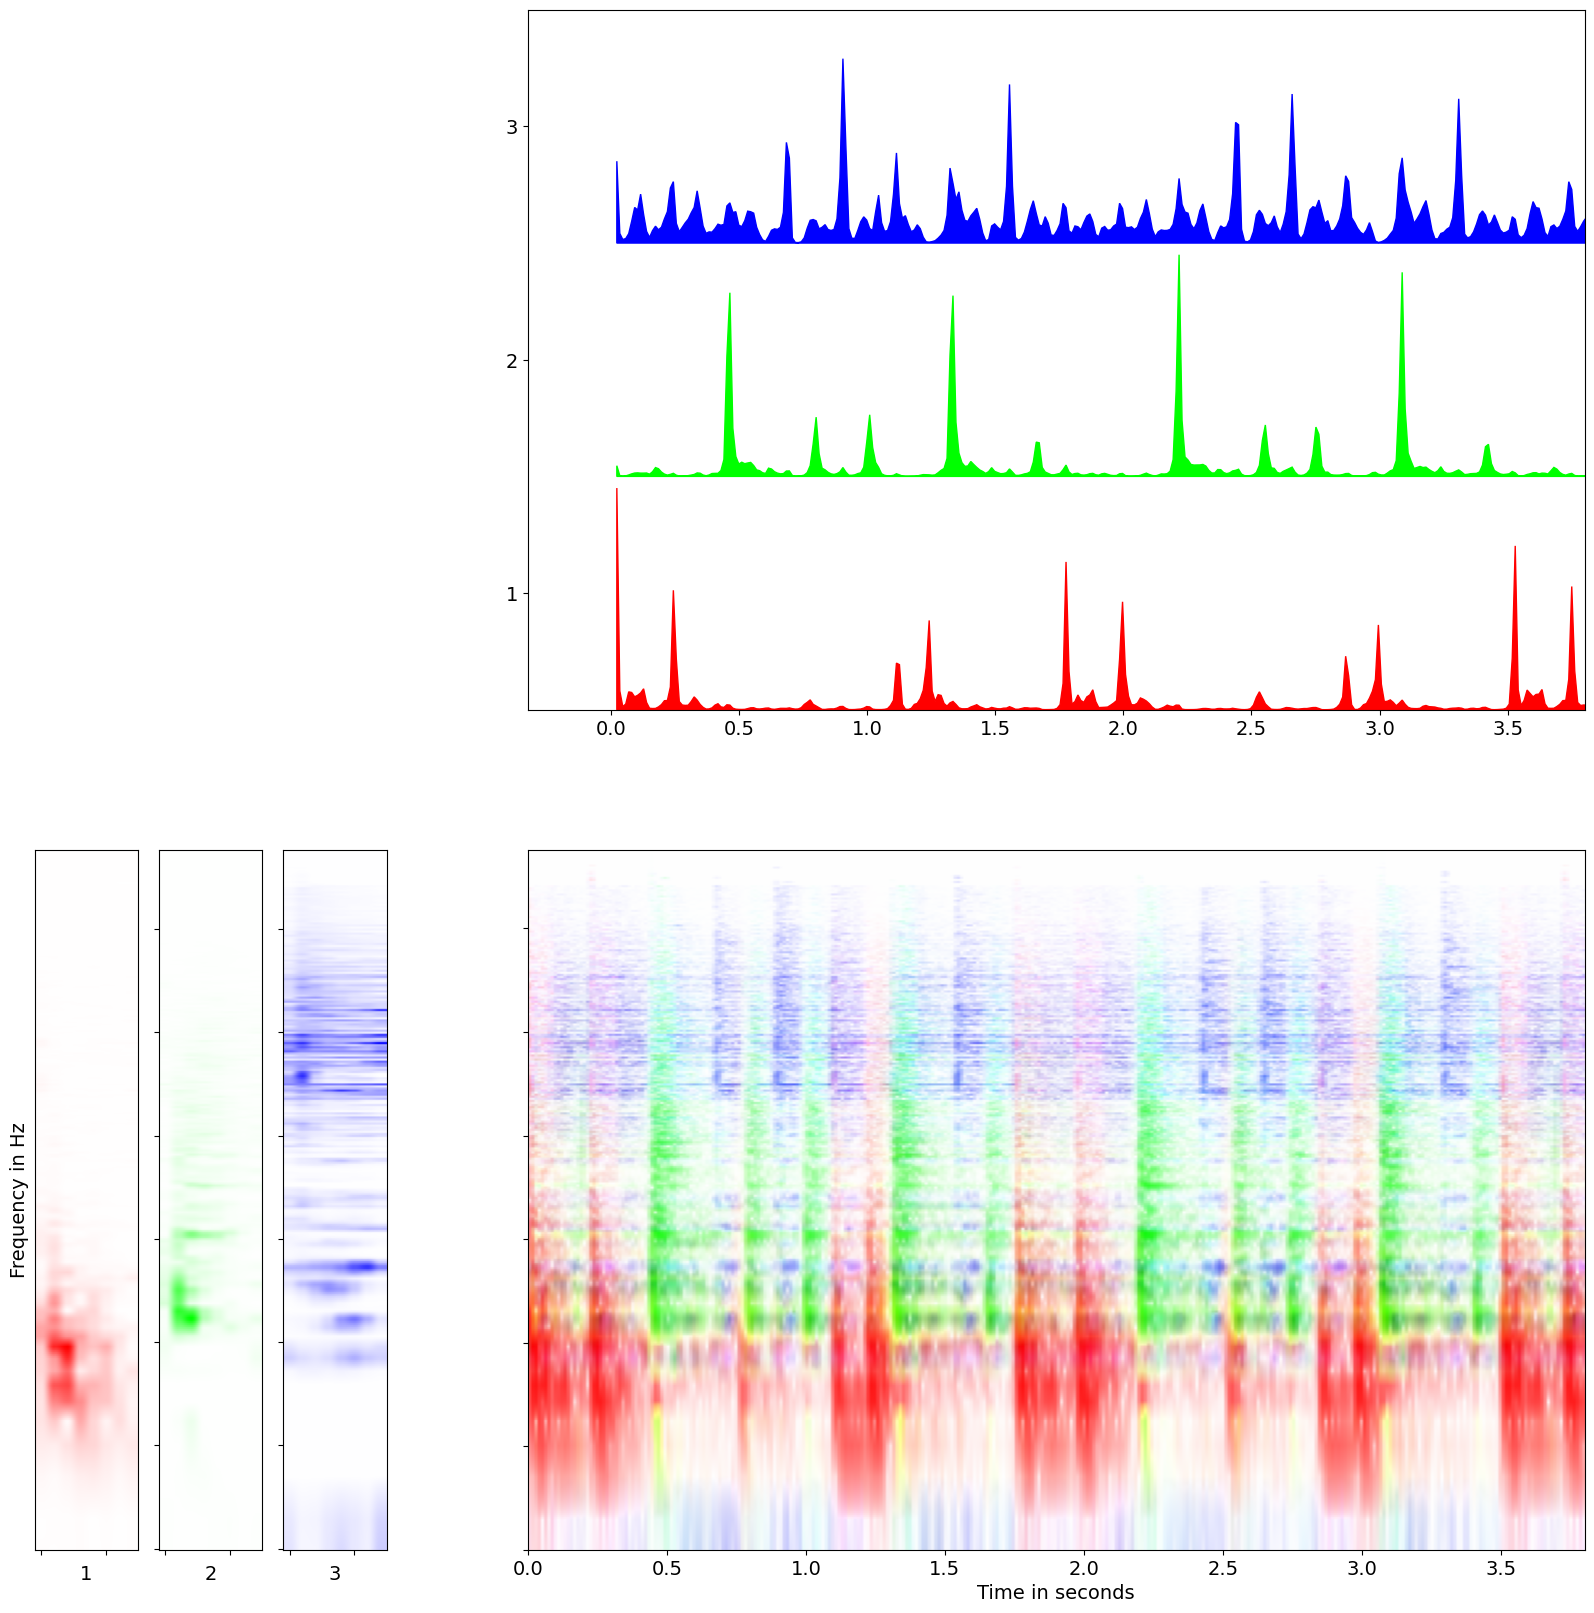

In [5]:
#visualize
fh1, _ = visualize_components_nmf(V=A, W=nmfd_W, H=nmfd_H, comp_V=nmfd_A, time_res=time_res,
                                  freq_res=freq_res, end_sec=3.8, font_size=14)

In [13]:
audios = []

# resynthesize results of NMF with soft constraints and score information
for k in range(num_comp):
    Y = nmfd_A[k] * np.exp(1j * P);
    y, _ = inverse_stft(X=Y,
                        block_size=BLOCK_SIZE,
                        hop_size=HOP_SIZE,
                        reconst_mirror=True,
                        append_frames=True,
                        num_samp=len(x))
    audios.append(y)
    
    # save result
    out_filepath = os.path.join(OUT_DIR,
                                'Winstons_AmenBreak_NMFD_component_{}.wav'.format(k, filename))
    
    sf.write(file=out_filepath, data=y, samplerate=fs)

#### Breakbeat with 3 components

In [14]:
ipd.Audio(x, rate=fs)

#### Kick Drum

In [15]:
ipd.Audio(audios[0].T, rate=fs)

#### Snare Drum

In [9]:
ipd.Audio(audios[1].T, rate=fs)

#### Ride Cymbal

In [10]:
ipd.Audio(audios[2].T, rate=fs)